# Подключение библиотек

In [6]:
import numpy as np
import gym
import random
from datetime import datetime
from collections import deque, Counter
import tensorflow
import matplotlib.pyplot as plt

In [7]:
tensorflow.__version__

'1.15.0'

In [ ]:
#pip uninstall tensorflow

In [ ]:
#pip install tensorflow==1.15

In [8]:
from tensorflow.contrib.layers import flatten, conv2d, fully_connected

In [9]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from tensorflow.keras import backend as K

In [23]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

# Q-learning

In [10]:
env = gym.make('LunarLander-v2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
episode: 1   reward: -460.36987898567224  avg so far:-460.36987898567224 exploreRate:0
episode: 2   reward: -479.71713884034824  avg so far:-470.0435089130102 exploreRate:0.01
episode: 3   reward: -106.1163886068041  avg so far:-348.7344688109415 exploreRate:0.01
episode: 4   reward: -151.0903826698219  avg so far:-299.3234472756616 exploreRate:0.01
episode: 5   reward: -376.46919993330306  avg so far:-314.7525978071899 exploreRate:0.01
episode: 6   reward: -99.32473541594015  avg so far:-278.84795407531493 exploreRate:0.01
episode: 7   reward: -198.4018220293798  avg so far:-267.3556494973242 exploreRate:0.01
episode: 8   reward: -150.75921299115018  avg so far:-252.78109493405245 exploreRate:0.01
episode: 9   reward: -184.20925786788052  avg so far:-245.16200192670001 exploreRate:0.01
episode: 10   reward: -129.07356063780026  avg so far:-233.55315779781003 exploreRate:0.01
episode: 11   reward: -150.588

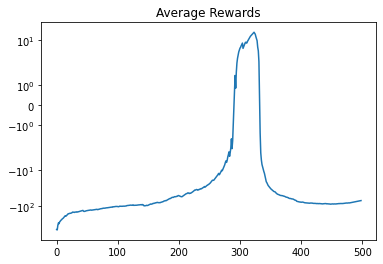

In [24]:
class replayBuffer:
  def __init__(self,maxSize,stateDim):
    self.state=np.zeros((maxSize,stateDim))
    self.action=np.zeros(maxSize,dtype= np.int8)
    self.reward=np.zeros(maxSize)
    self.done=np.zeros(maxSize,dtype= np.int8)
    self.nextState=np.zeros((maxSize,stateDim))
    self.maxSize=maxSize
    self.curser=0
    self.size=0

  def save(self,state,action,reward,nextState,done):
    self.state[self.curser]=state
    self.action[self.curser]=action
    self.reward[self.curser]=reward
    self.nextState[self.curser]=nextState
    self.done[self.curser]=done
    self.curser=(self.curser+1)%self.maxSize
    if self.size<self.maxSize:
      self.size+=1 
      
  def sample(self,batchSize):
    batchSize=min(self.size,batchSize-1)
    indexes=np.random.choice([i for i in range(self.size-1)],batchSize)
    return self.state[indexes],self.action[indexes],self.reward[indexes],self.nextState[indexes],self.done[indexes]

class Agent:
  def __init__(self,stateShape,actionShape,exploreRate=1.0,exploreRateDecay=0.9995,minimumExploreRate=0.01\
               ,gamma=0.99,saveAfterIterations=10000,modelName="DQN_LunarLanderV2.h"):
      self.gamma=gamma
      self.exploreRate=exploreRate
      self.exploreRateDecay=exploreRateDecay
      self.minimumExploreRate=minimumExploreRate
      self.actionShape=actionShape
      self.memory=replayBuffer(1000000,stateShape)
      self.buildModel(stateShape,actionShape)
      self.saveAfterIterations=saveAfterIterations
      self.updateIterations=0
      self.modelName=modelName
  
  def buildModel(self,input,output):
    inputLayer=keras.Input(shape=(input,))
    layer=Dense(256,activation='relu')(inputLayer)
    layer=Dense(256,activation='relu')(layer)
    outputLayer=Dense(output)(layer)
    self.model=keras.Model(inputs=inputLayer,outputs=outputLayer)
    self.model.compile(optimizer='Adam',loss='mse')

  def saveModel(self):
      self.model.save_weights(f"{self.modelName}")
      # print("model saved!")

  def loadModel(self):
      self.model.load_weights(f"{self.modelName}")
      # print("model sucsessfuly loaded!")

  def getAction(self,state):
    if np.random.random()<=self.exploreRate:
      return np.random.choice([i for i in range(env.action_space.n)])
    else:
      return np.argmax(self.model.predict(np.expand_dims(state,axis=0))[0])

  def exploreDecay(self):
      self.exploreRate=max(self.exploreRate*self.exploreRateDecay,self.minimumExploreRate)

  def learn(self,batchSize=64):
    if self.memory.size>batchSize:
      states,actions,rewards,nextStates,done=self.memory.sample(batchSize)
      qState=self.model.predict(states)
      qNextState=self.model.predict(nextStates)
      maxActions=np.argmax(qNextState,axis=1)
      batchIndex = np.arange(batchSize-1, dtype=np.int32)
      qState[batchIndex,actions]=(rewards+(self.gamma*qNextState[batchIndex,maxActions.astype(int)]*(1-done)))
      _=self.model.fit(x=states,y=qState,verbose=0)
      self.exploreDecay()

agent=Agent(stateShape=env.observation_space.shape[0],actionShape=env.action_space.n)
# agent.loadModel()

agent.exploreRate=0
averageRewards=[]
totalRewards=[]
for i in range(1,500):
  done=False
  state=env.reset()
  rewards=0
  while not done:
    action=agent.getAction(state)
    nextState,reward,done,info=env.step(action)
    agent.memory.save(state,action,reward,nextState,int(done))
    rewards+=reward
    state=nextState
    agent.learn(batchSize=64)
  totalRewards.append(rewards)
  averageRewards.append(sum(totalRewards)/len(totalRewards))
  print(f"episode: {i}   reward: {rewards}  avg so far:{averageRewards[-1]} exploreRate:{agent.exploreRate}")

plt.title(f'Total Rewards')
plt.yscale('symlog')
plt.plot(totalRewards)
plt.savefig("Total Rewards",dpi=200)
plt.clf()
plt.title(f'Average Rewards')
plt.yscale('symlog')
plt.plot(averageRewards)
plt.savefig("Average Rewards",dpi=200)

agent.saveModel()